In [1]:
import argparse
import logging
import os
import torch
from torch.utils.data import DataLoader, random_split
import json
import rdkit.Chem as Chem
import rdkit
from rxntorch.containers.reaction import Rxn
from rxntorch.containers.molecule import Mol
from rxntorch.containers.dataset import RxnGraphDataset as RxnGD
from rxntorch.utils import collate_fn
from rxntorch.models.yield_network import YieldNet as RxnNet, YieldTrainer as RxnTrainer
from rxntorch.models import yield_network
import warnings
warnings.filterwarnings("ignore")
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import numpy as np
from sklearn.metrics import roc_auc_score,r2_score

In [11]:
PATH='output/pre-trained-models/model_architecture/gat_supervised_contextpred.pth'
#model= net
#optimizer = opt.Adam(model.parameters(), lr=args.lr, betas=betas, weight_decay=0)
device = torch.device('cpu')
#checkpoint = torch.load(PATH, map_location=device)
#model.load_state_dict(checkpoint.state_dict())
model = torch.load(PATH, map_location=device)

In [12]:
for i in model.keys():
    print(i)

x_embedding1.weight
x_embedding2.weight
gnns.0.att
gnns.0.bias
gnns.0.weight_linear.weight
gnns.0.weight_linear.bias
gnns.0.edge_embedding1.weight
gnns.0.edge_embedding2.weight
gnns.1.att
gnns.1.bias
gnns.1.weight_linear.weight
gnns.1.weight_linear.bias
gnns.1.edge_embedding1.weight
gnns.1.edge_embedding2.weight
gnns.2.att
gnns.2.bias
gnns.2.weight_linear.weight
gnns.2.weight_linear.bias
gnns.2.edge_embedding1.weight
gnns.2.edge_embedding2.weight
gnns.3.att
gnns.3.bias
gnns.3.weight_linear.weight
gnns.3.weight_linear.bias
gnns.3.edge_embedding1.weight
gnns.3.edge_embedding2.weight
gnns.4.att
gnns.4.bias
gnns.4.weight_linear.weight
gnns.4.weight_linear.bias
gnns.4.edge_embedding1.weight
gnns.4.edge_embedding2.weight
batch_norms.0.weight
batch_norms.0.bias
batch_norms.0.running_mean
batch_norms.0.running_var
batch_norms.0.num_batches_tracked
batch_norms.1.weight
batch_norms.1.bias
batch_norms.1.running_mean
batch_norms.1.running_var
batch_norms.1.num_batches_tracked
batch_norms.2.weight


In [2]:
parser = argparse.ArgumentParser()

parser.add_argument("-p", "--dataset_path", type=str, default='./data/', help="train dataset")
parser.add_argument("-mp","--mol_path", type=str, default='doyle_reaction_mols', help="path to mol files")

parser.add_argument("-c", "--train_dataset", required=True, type=str, help="train dataset")
parser.add_argument("-t", "--test_dataset", type=str, default=None, help="test set")
parser.add_argument("-op", "--output_path", type=str, default='./output/', help="saved model path")
parser.add_argument("-o", "--output_name", required=True, type=str, help="e.g. rxntorch.model")
parser.add_argument("-ds", "--train_split", type=float, default=0.7, help="Ratio of samples to reserve for test data")
parser.add_argument("-vs", "--valid_split", type=float, default=0.333, help="Ratio of samples to reserve for valid data")
parser.add_argument("-dr", "--dropout_rate", type=float, default=0.333, help="Ratio of samples to reserve for valid data")

parser.add_argument("-b", "--batch_size", type=int, default=1, help="number of batch_size")
parser.add_argument("-tb", "--test_batch_size", type=int, default=None, help="batch size for evaluation")
parser.add_argument("-e", "--epochs", type=int, default=10, help="number of epochs")
parser.add_argument("-hs", "--hidden", type=int, default=200, help="hidden size of model layers")
parser.add_argument("-l", "--layers", type=int, default=3, help="number of layers")

parser.add_argument("--lr", type=float, default=1e-2, help="learning rate of the optimizer")
parser.add_argument("-lrd", "--lr_decay", type=float, default=0.9,
                    help="Decay factor for reducing the learning rate")
parser.add_argument("-lrs", "--lr_steps", type=int, default=10000,
                    help="Number of steps between learning rate decay")
parser.add_argument("-awd","--adam_weight_decay", type=float, default=0.0, help="weight_decay of adam")
parser.add_argument("--adam_beta1", type=float, default=0.9, help="adam first beta value")
parser.add_argument("--adam_beta2", type=float, default=0.999, help="adam second beta value")
parser.add_argument("-gc", "--grad_clip", type=float, default=None, help="value for gradient clipping")
parser.add_argument("-pw", "--pos_weight", type=float, default=None, help="Weights positive samples for imbalance")

parser.add_argument("-w", "--num_workers", type=int, default=4, help="dataloader worker size")
parser.add_argument("--with_cuda", type=bool, default=True, help="training with CUDA: true, or false")
parser.add_argument("--cuda_devices", type=int, nargs='*', default=None, help="CUDA device ids")

parser.add_argument("--log_freq", type=int, default=50, help="printing loss every n iter: setting n")
parser.add_argument("--seed", type=int, default=12, help="random seed")
parser.add_argument("-ud","--use_domain", type=str, required='True', help="use domain features or not")

_StoreAction(option_strings=['-ud', '--use_domain'], dest='use_domain', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, help='use domain features or not', metavar=None)

In [16]:
#args = parser.parse_args()
data_type='doyle'
args = parser.parse_args(args=['-p','data/','-c', data_type+'_reactions_data.json', '-o', 'model.01','-ud', 'False', '-mp', data_type+'_reaction_mols'])
random_seed=args.seed
args.output_name="reactivity.model"

if not os.path.exists(args.output_path):
    os.mkdir(args.output_path)
outputfile = os.path.join(args.output_path, args.output_name)
logfile = '.'.join((args.output_name, "log"))
logpath = os.path.join(args.output_path, logfile)
logging.basicConfig(level=logging.INFO, style='{', format="{asctime:s}: {message:s}",
                    datefmt="%m/%d/%y %H:%M:%S", handlers=(
                    logging.FileHandler(logpath), logging.StreamHandler()))

logging.info("{:-^80}".format("Dataset"))
su_dataset = RxnGD('suzuki_reactions_data.json', mol_path=args.mol_path, path=args.dataset_path)
dy_dataset = RxnGD('doyle_reactions_data.json', mol_path=args.mol_path, path=args.dataset_path)
az_dataset = RxnGD('az_reactions_data.json', mol_path=args.mol_path, path=args.dataset_path)

sample = dy_dataset[3]
sample['atom_feats'].shape, sample['bond_feats'].shape, sample['atom_graph'].shape,sample['bond_graph'].shape,sample['domain_feats'].shape,sample["binary_feats"].shape

02/02/21 11:37:08: ------------------------------------Dataset-------------------------------------
02/02/21 11:37:08: Loading Dataset suzuki_reactions_data.json in data/
02/02/21 11:37:19: Dataset contains 0 total samples
02/02/21 11:37:28: Dataset contains 4620 total samples
02/02/21 11:37:30: Dataset contains 4620 total samples
02/02/21 11:37:30: Loading Dataset doyle_reactions_data.json in data/
02/02/21 11:37:40: Dataset contains 4599 total samples
02/02/21 11:37:49: Dataset contains 4599 total samples
02/02/21 11:37:51: Dataset contains 4599 total samples
02/02/21 11:37:51: Loading Dataset az_reactions_data.json in data/
02/02/21 11:38:00: Dataset contains 0 total samples
02/02/21 11:38:09: Dataset contains 0 total samples
02/02/21 11:38:10: Dataset contains 757 total samples


(torch.Size([64, 29]),
 torch.Size([66, 6]),
 torch.Size([64, 15]),
 torch.Size([64, 15]),
 torch.Size([1, 118]),
 torch.Size([15, 15, 15]))

In [4]:
p=0.8;p0=0.5
n1=4620;n2=4599;n3=757
print(p*n1, round((1-p)*n1))
print(round(p*n2),round( (1-p)*n2))
print(p0*n3, (1-p0)*n3)

3696.0 924
3679 920
378.5 378.5


In [17]:
afeats_size, bfeats_size, binary_size, dmfeats_size = (sample["atom_feats"].shape[-1], sample["bond_feats"].shape[-1],
                                        sample["binary_feats"].shape[-1], sample['domain_feats'].shape[-1])
d1,d2,d3 = sample["binary_feats"].shape
binary_size= d3*d2


test_batch_size = args.test_batch_size if args.test_batch_size is not None else args.batch_size
su_dataloader = DataLoader(su_dataset, batch_size=test_batch_size, num_workers=args.num_workers, collate_fn=collate_fn)
az_dataloader = DataLoader(az_dataset, batch_size=test_batch_size, num_workers=args.num_workers, collate_fn=collate_fn)
dy_dataloader = DataLoader(dy_dataset, batch_size=test_batch_size, num_workers=args.num_workers, collate_fn=collate_fn)


torch.manual_seed(random_seed)
net = RxnNet(depth=args.layers, dropout=args.dropout_rate, afeats_size=afeats_size, bfeats_size=bfeats_size,
             hidden_size=args.hidden, binary_size=binary_size,dmfeats_size=dmfeats_size, use_domain=args.use_domain)
trainer = RxnTrainer(net, lr=args.lr, betas=(args.adam_beta1, args.adam_beta2), weight_decay=args.adam_weight_decay,
                     with_cuda=args.with_cuda, cuda_devices=args.cuda_devices, log_freq=args.log_freq,
                     grad_clip=args.grad_clip, pos_weight=args.pos_weight, lr_decay=args.lr_decay,
                     lr_steps=args.lr_steps)

In [40]:
PATH='output/dy_model_5.0.1-no_domain-11-200-1-100-0.01-0.9-10000-40/yield.model'
#model = torch.nn.DataParallel(net)
model= net
betas=(args.adam_beta1,args.adam_beta2)
optimizer = opt.Adam(model.parameters(), lr=args.lr, betas=betas, weight_decay=0)
device = torch.device('cpu')
#checkpoint = torch.load(PATH, map_location=device)
#model.load_state_dict(checkpoint.state_dict())
model = torch.load(PATH, map_location=device)

In [80]:
for name, child in model.named_children():
    print('name: ', name)
    print('isinstance({}, nn.Module): '.format(name), isinstance(child, nn.Module))
    print('=====')


name:  wln
isinstance(wln, nn.Module):  True
=====
name:  attention
isinstance(attention, nn.Module):  True
=====
name:  yield_scoring
isinstance(yield_scoring, nn.Module):  True
=====
name:  dropout
isinstance(dropout, nn.Module):  True
=====


In [79]:
for name , param in model.named_parameters(): 
    print('type(param): ', type(param))
    print('isinstance(param, nn.Module): ', isinstance(param, nn.Module))
    print('isinstance(param, nn.Parameter): ', isinstance(param, nn.Parameter))
    print('isinstance(param, torch.Tensor) ', isinstance(param, torch.Tensor))
    print("requires grad: " , name, ':', param.requires_grad)
    print('=====')
    

type(param):  <class 'torch.nn.parameter.Parameter'>
isinstance(param, nn.Module):  False
isinstance(param, nn.Parameter):  True
isinstance(param, torch.Tensor)  True
requires grad:  wln.fc1.weight : True
=====
type(param):  <class 'torch.nn.parameter.Parameter'>
isinstance(param, nn.Module):  False
isinstance(param, nn.Parameter):  True
isinstance(param, torch.Tensor)  True
requires grad:  wln.graph_conv_nei.weight : True
=====
type(param):  <class 'torch.nn.parameter.Parameter'>
isinstance(param, nn.Module):  False
isinstance(param, nn.Parameter):  True
isinstance(param, torch.Tensor)  True
requires grad:  wln.graph_conv_nei.bias : True
=====
type(param):  <class 'torch.nn.parameter.Parameter'>
isinstance(param, nn.Module):  False
isinstance(param, nn.Parameter):  True
isinstance(param, torch.Tensor)  True
requires grad:  wln.graph_conv_atom.weight : True
=====
type(param):  <class 'torch.nn.parameter.Parameter'>
isinstance(param, nn.Module):  False
isinstance(param, nn.Parameter):  

In [78]:
model.modules

<bound method Module.modules of YieldNet(
  (wln): WLNet(
    (fc1): Linear(in_features=29, out_features=200, bias=False)
    (graph_conv_nei): Linear(in_features=206, out_features=200, bias=True)
    (graph_conv_atom): Linear(in_features=400, out_features=200, bias=True)
    (fc2atom_nei): Linear(in_features=200, out_features=200, bias=False)
    (fc2bond_nei): Linear(in_features=6, out_features=200, bias=False)
    (fc2): Linear(in_features=200, out_features=200, bias=False)
    (dropout): Dropout(p=0.04, inplace=False)
  )
  (attention): Attention(
    (fcapair): Linear(in_features=200, out_features=200, bias=False)
    (fcbinary): Linear(in_features=15, out_features=200, bias=True)
    (fcattention): Linear(in_features=200, out_features=1, bias=True)
  )
  (yield_scoring): YieldScoring(
    (fclocal): Linear(in_features=200, out_features=200, bias=False)
    (fcglobal): Linear(in_features=200, out_features=200, bias=True)
    (fcbinary): Linear(in_features=225, out_features=200, bi

In [73]:
class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []

save_output = SaveOutput()

hook_handles = []

for layer in model.modules():
    if isinstance(layer, graph_conv_nei):
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)


NameError: name 'graph_conv_nei' is not defined

In [66]:
len(save_output.outputs)

0

In [68]:
az_dataset[3]['yield_label']

tensor([0.7507])

In [69]:
print(len(az_dataloader))
model.eval()
for i, data in enumerate(az_dataloader):
    if i<=3:
        if i==3:
            mask_neis = torch.unsqueeze(data['n_bonds'].unsqueeze(-1) > torch.arange(0, 15, dtype=torch.int32).view(1, 1, -1), -1)
            max_n_atoms = data['n_atoms'].max()
            mask_atoms = torch.unsqueeze(data['n_atoms'].unsqueeze(-1) > torch.arange(0, max_n_atoms, dtype=torch.int32).view(1, -1),-1)
            with torch.no_grad():
                model.eval()
                yield_scores = model.forward(data['atom_feats'], data['bond_feats'],data['atom_graph'], 
                                                        data['bond_graph'], data['n_bonds'],data['n_atoms'], data['binary_feats'], 
                                                        mask_neis, mask_atoms,data['sparse_idx'],data['domain_feats'])
                print(yield_scores)
    else:
        break


757
tensor([[0.1944]])


In [70]:
yield_scores,len(save_output.outputs)

(tensor([[0.1944]]), 18)

In [71]:
res=[]

for i in range(len(save_output.outputs)):
    np.save('data/image_'+str(i)+'.npy', save_output.outputs[i].detach().to('cpu').numpy())
    #res.append(save_output.outputs[i].detach().to('cpu').numpy())
#image= save_output.outputs.detach().to('cpu').numpy()    


In [13]:
def iterate(model,optimizer,epoch, data_loader, train=True,valid=False):
    avg_loss, tmp_r2 =0.0, 0
    iters = len(data_loader)
    n_samples = len(data_loader.dataset)
    correct_yields , pred_yields =np.array([[0]]), np.array([[0]])
    model.eval()
    if True:
        for i, data in enumerate(data_loader):
            mask_neis = torch.unsqueeze(data['n_bonds'].unsqueeze(-1) > torch.arange(0, 15, dtype=torch.int32).view(1, 1, -1), -1)
            max_n_atoms = data['n_atoms'].max()
            mask_atoms = torch.unsqueeze(data['n_atoms'].unsqueeze(-1) > torch.arange(0, max_n_atoms, dtype=torch.int32).view(1, -1),-1)
            with torch.no_grad():
                model.eval()
                yield_scores = model.forward(data['atom_feats'], data['bond_feats'],data['atom_graph'], 
                                                    data['bond_graph'], data['n_bonds'],data['n_atoms'], data['binary_feats'], 
                                                    mask_neis, mask_atoms,data['sparse_idx'],data['domain_feats'])
                criteria=nn.MSELoss()
                loss= criteria(yield_scores, data['yield_label'])
                loss = torch.mean(loss)
                avg_loss += loss.item()
                aa=data['yield_label'].cpu().detach().numpy()
                bb=yield_scores.cpu().detach().numpy()
                correct_yields=np.append(correct_yields,aa)
                pred_yields=np.append(pred_yields,bb)

        tmp_r2=r2_score(correct_yields,pred_yields)
        logging.info("Epoch: {:2d}  Loss: {:f}  R2: {:6.2%} ".format(epoch,avg_loss, tmp_r2))
        return correct_yields,pred_yields,tmp_r2,avg_loss


In [14]:
correct_yields,pred_yields, r2 ,loss= iterate( model,optimizer,1, dy_dataloader, train=False,valid=False)

02/02/21 11:35:08: Epoch:  1  Loss: 28.884723  R2: 91.86% 


In [18]:
correct_yields,pred_yields, r2 ,loss= iterate( model,optimizer,1, az_dataloader, train=False,valid=False)

02/02/21 11:40:26: Epoch:  1  Loss: 133.645681  R2: -103.15% 


In [21]:
correct_yields,pred_yields, r2 ,loss= iterate( model,optimizer,1, su_dataloader, train=False,valid=False)

02/02/21 11:42:58: Epoch:  1  Loss: 872.601692  R2: -128.78% 


In [22]:
np.mean(pred_yields),np.std(pred_yields)

(0.11045819235104222, 0.07012773506296444)

In [23]:
np.mean(correct_yields),np.std(correct_yields)

(0.4178988746543945, 0.2872947228123882)

In [24]:
print(sorted([round(i,2) for i in list(pred_yields)]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01

In [18]:
with open('data/'+args.output_name+'_y_true.txt', 'w') as f_true, open('data/'+args.output_name+'_y_pred.txt', 'w') as f_pred:
    f_true.write(','.join(map(str, [float(n[0]) for n in a2])))
    f_pred.write(','.join(map(str, [float(n[0]) for n in b2])))
    
    
with open('data/'+args.output_name+'_train_scores.txt', 'w') as train_r2, open('data/'+args.output_name+'_test_scores.txt', 'w') as test_r2:
    train_r2.write(','.join(map(str, [float(n) for n in train_scores])))
    test_r2.write(','.join(map(str, [float(n) for n in test_scores])))

In [ ]:
roc_auc_score( data['yield_label'].cpu(), yield_scores.cpu().detach().numpy() )

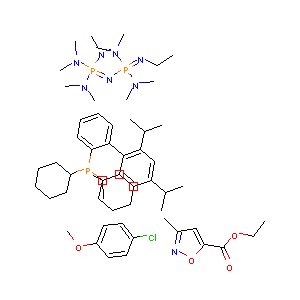

In [13]:
from rdkit.Chaem import Draw
Draw.MolToImage(mol)
#Chem.FindMolChiralCenters(mol,force=True)

In [11]:
m = Chem.MolFromMolFile('data/doyle_reaction_mols/1-bromo-4-ethylbenzene.mol')
m.GetNumAtoms()
AllChem.Compute2DCoords(m)
for atom in m.GetAtoms():
    print(atom.GetSymbol(),atom.GetIdx())



C 0
C 1
C 2
C 3
C 4
C 5
C 6
C 7
Br 8


In [14]:
import re
import glob


def get_atom_mapping_doyle(mol_dir):
    
    smiles_mapping=defaultdict(dict) 
    
    for mol_fn in glob.glob(mol_dir):
        atoms , labels, atom_mapping =[], [], []
        if 'methyl-isoxazole-5-carboxylate' in mol_fn:
            print(mol_fn)
            m = Chem.MolFromMolFile(mol_fn)
            smiles=Chem.MolToSmiles(m)
            mol_lines=open(mol_fn,'r').readlines()

            for i,line in enumerate(mol_lines[4:]):
                l=re.sub(' +', ' ', line.strip('\n'))
                l2=l.split(' ')
                if len(l2)==17:
                    atom=l2[4]
                    if atom !='' and '*' not in atom and 'H' not in atom:
                        atoms.append(atom)
                if "atom_labels" in line:
                    labels=[i.strip('*') for i in mol_lines[i+1+4].strip('\n').split(' ') if ((i!='') and ('H' not in i))]
                    print(labels)
            if len(atoms)==len(labels):
                for i in range(len(atoms)):
                    atom_mapping.append((atoms[i],labels[i]))            
                print(atom_mapping)
            else:
                print('Atoms and lables don\'t match')
                atom_mapping=[]

            if smiles not in smiles_mapping:
                print(mol_fn.split('/')[-1].split('.')[0])
                smiles_mapping[mol_fn.split('/')[-1].split('.')[0]]=atom_mapping
            else:
                print("key exsists")
    return smiles_mapping



In [ ]:
ope

In [22]:
for mol_fn in glob.glob("data/doyle_reaction_mols/*.mol"):
    if 'methyl-isoxazole-5-carboxylate' in mol_fn:
        print("te")

te


In [15]:
smiles_mapping=get_atom_mapping_doyle("data/doyle_reaction_mols/*.mol")

data/doyle_reaction_mols/methyl-isoxazole-5-carboxylate.mol
['O1', 'N1', 'C3', 'C4', 'C5', 'C1', 'O1', 'O2', 'C2']
[('O', 'O1'), ('N', 'N1'), ('C', 'C3'), ('C', 'C4'), ('C', 'C5'), ('C', 'C1'), ('O', 'O1'), ('O', 'O2'), ('C', 'C2')]
methyl-isoxazole-5-carboxylate


In [16]:
smiles_mapping['methyl-isoxazole-5-carboxylate']

[('O', 'O1'),
 ('N', 'N1'),
 ('C', 'C3'),
 ('C', 'C4'),
 ('C', 'C5'),
 ('C', 'C1'),
 ('O', 'O1'),
 ('O', 'O2'),
 ('C', 'C2')]

In [13]:
smiles_mapping['methyl-isoxazole-5-carboxylate']

{}

In [30]:
smiles_mapping['1-bromo-4-ethylbenzene']

[('C', 'C1'),
 ('C', 'C4'),
 ('C', 'C2'),
 ('C', 'C2'),
 ('C', 'C3'),
 ('C', 'C3'),
 ('C', 'C4'),
 ('C', 'C1'),
 ('Br', 'Br1')]

In [148]:
atoms=[{"name": "C1", "atomic_num": 6, "partial_charge": -0.025, "nmr_shift": 132.85}, {"name": "C2", "atomic_num": 6, "partial_charge": -0.058, "nmr_shift": 125.36}, {"name": "C3", "atomic_num": 6, "partial_charge": -0.211, "nmr_shift": 122.91}, {"name": "C4", "atomic_num": 6, "partial_charge": 0.167, "nmr_shift": 136.02}, {"name": "H2", "atomic_num": 1, "partial_charge": 0.104, "nmr_shift": 7.11}, {"name": "H3", "atomic_num": 1, "partial_charge": 0.14, "nmr_shift": 6.97}]

In [161]:
p_charge_dict=defaultdict(float)
nmr_dict=defaultdict(float)
for atom in atoms:
    p_charge_dict[atom['name']]=atom['partial_charge']
    nmr_dict[atom['name']]=atom['nmr_shift']

In [162]:
p_charge_dict

defaultdict(float,
            {'C1': -0.025,
             'C2': -0.058,
             'C3': -0.211,
             'C4': 0.167,
             'H2': 0.104,
             'H3': 0.14})

In [166]:
m=Chem.MolFromMolFile('data/doyle_reaction_mols/1-bromo-4-ethylbenzene.mol')
partial_charges=[]
nmr_shifts=[]

for atom in m.GetAtoms():
    atom_label=smiles_mapping['1-bromo-4-ethylbenzene'][atom.GetIdx()][1]
    partial_charges.append(p_charge_dict[atom_label])
    nmr_shifts.append(nmr_dict[atom_label])
    


In [165]:
partial_charges

[-0.025, 0.167, -0.058, -0.058, -0.211, -0.211, 0.167, -0.025, 0.0]

In [167]:
nmr_shifts

[132.85, 136.02, 125.36, 125.36, 122.91, 122.91, 136.02, 132.85, 0.0]

In [92]:
mm=Chem.MolFromSmiles('CCc1ccc(Br)cc1')

In [123]:
mm.GetAtoms()

In [126]:
for atom in mm.GetAtoms():
    print(atom.GetIdx(),atom.GetSymbol())

0 C
1 C
2 C
3 C
4 C
5 C
6 Br
7 C
8 C


In [ ]:
m = Chem.MolFromMolFile('data/doyle_reaction_mols/1-bromo-4-ethylbenzene.mol')
m.GetNumAtoms()
Chem.MolToSmiles(m)
#AllChem.Compute2DCoords(m2)
#for atom in m.GetAtoms():
    #print(atom.GetSymbol(),atom.GetIdx())
#print(Chem.MolToMolBlock(m))

In [177]:
import math
from sklearn.preprocessing import LabelEncoder
file_name = args.train_dataset
path = args.dataset_path
rxns = []
degree_codec = LabelEncoder()
symbol_codec = LabelEncoder()
expl_val_codec = LabelEncoder()
bond_type_codec = LabelEncoder()
max_nbonds = 10   
symbols = set()
degrees = set()
explicit_valences = set()
bond_types = set()

a=True
charges,shifts=[math.inf,-math.inf],[math.inf,-math.inf]
with open(os.path.join(path, file_name)) as datafile:
    data = json.load(datafile)
    for line in data:

        product=line['product']
        reactants=line['reactants']
        r_yield=line['yield']
     
        rxn = Rxn(product,reactants,r_yield)
        mol = Chem.MolFromSmiles(rxn.reactants_smile)
        #atom_idx = torch.tensor([atom.GetIdx()-1 for atom in mol.GetAtoms()], dtype=torch.int64)

        mol_reactants=rxn.reactants
        for mol_idx in range(1,len(mol_reactants)):
            current_molecule=mol_reactants[mol_idx]
            atoms=current_molecule.atoms
            #p_charge_dict=defaultdict(float)
            #nmr_dict=defaultdict(float)
            for atom in atoms:
                if 'partial_charge' in atom:
                    charges[0],charges[1]= min(charges[0],atom['partial_charge']), max(charges[1],atom['partial_charge'])
                if 'nmr_shift' in atom:
                    shifts[0],shifts[1]= min(shifts[0],atom['nmr_shift']), max(shifts[1],atom['nmr_shift'])

In [178]:
charges

[-0.96, 1.858]

In [179]:
shifts

[6.41, 168.89]